In [7]:
import xarray as xr

xrds = xr.open_dataset("data/era5_wind_1980_01.nc")

xrds.data_vars



Data variables:
    u10      (valid_time, latitude, longitude) float32 19MB ...
    v10      (valid_time, latitude, longitude) float32 19MB ...
    u100     (valid_time, latitude, longitude) float32 19MB ...
    v100     (valid_time, latitude, longitude) float32 19MB ...

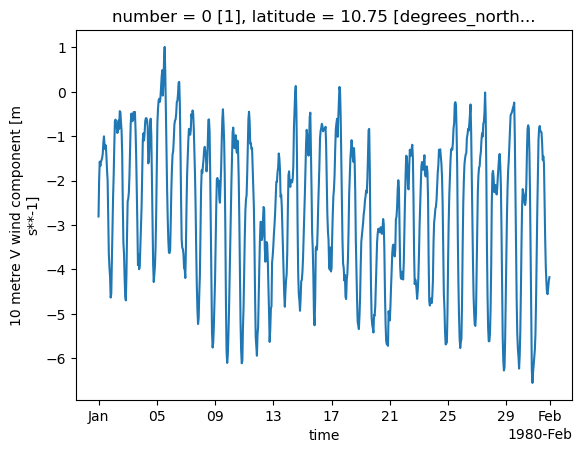

In [8]:

xrds['v10'][:,13,74].plot()